In [1]:
import os, sys
sys.path.insert(1, 'codes')  # insert at 1, 0 is the script path (or '' in REPL)

print("----------------")
!python --version
!nvidia-smi
print("----------------")
print("System Version: ", sys.version)

## ======================================================== ##
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from plot_functions import add_colorbar, imagesc

print("PyTorch Version: ", torch.__version__)
print("----------------")
print("torch.cuda.is_available: ",torch.cuda.is_available())
print("----------------")
print(torch.__version__, torch.version.cuda, torch.cuda.get_device_name(0))
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# deterministic behavior
torch.manual_seed(3)
torch.cuda.manual_seed_all(3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(3)
# random.seed(3)
os.environ['PYTHONHASHSEED'] = str(3)

----------------
Python 3.10.9
Tue May 14 23:32:52 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:81:00.0  On |                  Off |
|  0%   38C    P8    35W / 450W |   1908MiB / 24564MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:C1:00.0 Off | 

In [2]:
# deterministic behavior
def seed_everything(seed):
    import os
    import torch
    import random
    import numpy as np
    random.seed(seed)            # Python random module
    np.random.seed(seed)         # Numpy Module
    torch.manual_seed(seed)      # Current CPU
    torch.cuda.manual_seed(seed) # Current GPU
    torch.cuda.manual_seed_all(seed) # All GPU
    torch.backends.cudnn.benchmark = False    # Close Optimization
    torch.backends.cudnn.deterministic = True # Close Optimization
    os.environ['PYTHONHASHSEED'] = str(seed)
    

# 设置一个种子
seed = 37
# 调用函数以设置种子
seed_everything(seed)


Original Model Shape: (375, 1151), Grid Interval: 8m
Resampled Model Shape: (128, 256), Grid Interval: 15m
Number of shots: 12, with interval: 300m, in depth: 0m
tensor([[ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240]])


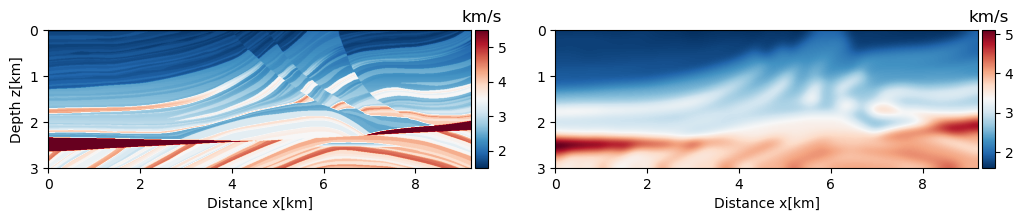

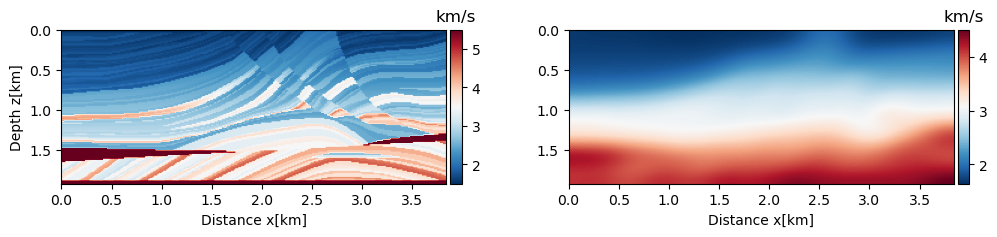

In [3]:
import pandas as pd
from scipy.ndimage import gaussian_filter

# Load the velocity model 
vmodel = np.array(pd.read_csv("./vel_marmousi_376x1151.csv")) 
v_init = np.array(pd.read_csv("./vel_marmousi_376x1151.csv"))
v_init = gaussian_filter(v_init, sigma=15)

dz = 8
nz, nx = vmodel.shape
print("Original Model Shape: {}, Grid Interval: {}m".format(vmodel.shape, dz))

################# Plot true & initial velocity model #################
fig = plt.figure(figsize=(12, 2))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]")
im = ax.imshow(vmodel/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')

ax = fig.add_subplot(gs[0, 1])
ax.set( xlabel="Distance x[km]")
im = ax.imshow(v_init/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
################# Plot true & initial velocity model #################


dz = 15
vp_tensor_init = torch.from_numpy(vmodel).type(dtype=torch.float32).to(device)
vi_tensor_init = torch.from_numpy(v_init).type(dtype=torch.float32).to(device)
sea = (torch.ones([9,1151])*5500).type(dtype=torch.float32).to(device)
vp_tensor = torch.cat([vp_tensor_init, sea], axis=0)[None, ::3, 60:1084:4]
vi_tensor = torch.cat([vp_tensor_init, sea], axis=0)[None, ::3, 60:1084:4]
vi_tensor = torch.from_numpy(gaussian_filter(vi_tensor.cpu().numpy(), sigma=10)).type(dtype=torch.float32).to(device)

nv, nz, nx = vp_tensor.shape
print("Resampled Model Shape: {}, Grid Interval: {}m".format((nz, nx), dz))

# Setting locations of sources and receivers
xs = torch.arange(20, nx-10, 20, dtype=torch.long).repeat([nv, 1])      # x-coordinate for sources
ns = xs.shape[1]                                                        # number of shots 
xr = torch.arange(0, nx, 1, dtype=torch.long).repeat([nv, ns, 1])       # x-coordinate for receivers
zs = torch.full((nv, ns), 0, dtype=torch.long)                          # depth of sources    震源深度
zr = torch.full((nv, ns, nx), 0, dtype=torch.long)                      # depth of receivers 地表
print("Number of shots: {}, with interval: {}m, in depth: {}m".format(ns, (xs[0, 1]-xs[0, 0])*dz, zs[0, 0]*dz))
print(xs)

################# Plot true & initial velocity model #################
fig = plt.figure(figsize=(12, 2))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]")
im = ax.imshow(vp_tensor[0].cpu().numpy()/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=0.8, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')

ax = fig.add_subplot(gs[0, 1])
ax.set( xlabel="Distance x[km]")
im = ax.imshow(vi_tensor[0].cpu().numpy()/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=0.8, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# ################# Plot true & initial velocity model #################

In [32]:
vp_tensor.max()

tensor(5500., device='cuda:0')

In [31]:
vp_tensor.min()

tensor(1500., device='cuda:0')

tensor(0.9852, device='cuda:1') < 1
tensor(1.2500, device='cuda:1') > 1


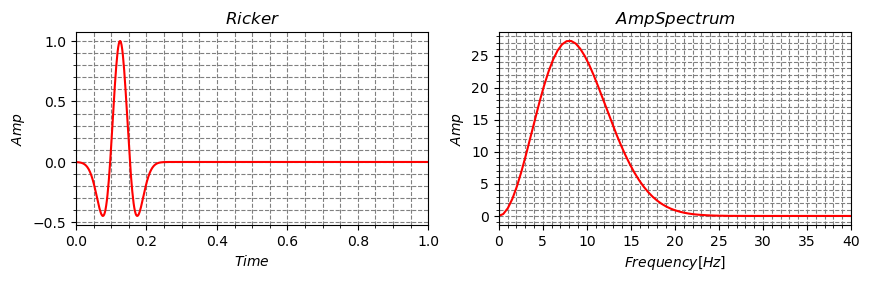

In [4]:
from rnn_fd import rnn2D
from generator_old import wGenerator #单频雷克子波

freeSurface = True                                                      # free surface option for forward modeling
npad = 15                                                               # velocity padding in grid points
freq = 8                                                               # dominant frequency of wavelet in Hz
dt = 0.0019                                                            # time samling interval, fixed for all shots gathers
nt = 1024                                                              # number of samples in time
t = dt * torch.arange(0, nt, dtype=torch.float32)                       # create time vector
wavelet = wGenerator(t, freq).ricker().to(device)                       # generate wavelet
nx_pad = nx + 2 * npad
nz_pad = nz + npad if freeSurface else nz + 2 * npad
f = np.arange(0, nt/2+1) / (nt*dt)

fig = plt.figure(figsize=(10, 2.5))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
ax.set(xlabel="$Time$", ylabel="$Amp$", title="$Ricker$", xlim=[0, 1])
ax.plot(t, wavelet.cpu().numpy(), color='red', linestyle='-', linewidth=1.5)
ax.grid(True, which='both', linestyle='--', color='grey', linewidth=.8, alpha=1.0)
ax.minorticks_on()

ax = fig.add_subplot(gs[0, 1])
ax.set(xlabel="$Frequency [Hz]$", ylabel="$Amp$", title="$Amp Spectrum$", xlim=[0, 40])
ax.plot(f, np.abs(torch.fft.rfft(wavelet).cpu().numpy()), color='red', linestyle='-', linewidth=1.5)
ax.grid(True, which='both', linestyle='--', color='grey', linewidth=.8, alpha=1.0)
ax.minorticks_on()

################## Check the stability condition #################
print(vp_tensor.max()*dt/dz/np.sqrt(1/2),"< 1") # should <1
print(vp_tensor.min()/10/freq/dz,"> 1") # should >1

forward_rnn = rnn2D(nz, nx, zs, xs, zr, xr, dz, dt, 
                    npad=npad, order=2, vmax=vp_tensor.max(), 
                    log_para=1e-6,
                    freeSurface=True, 
                    dtype=torch.float32, 
                    device=device).to(device)

# # forward modeling
# _, _, shots, _ = forward_rnn(vmodel=vp_tensor.to(device), segment_wavelet=wavelet)
# _, _, shots_init, _ = forward_rnn(vmodel=vi_tensor.to(device), segment_wavelet=wavelet)

In [6]:
shots = torch.load("./shots_marmousi_I_2048.npz")

In [7]:
#二维傅里叶变换和滤波函数
# 输入data是某一炮记录（nt, nx）=（4000*1151），输入是某一道记录（nt, nx）=（4000*1）

def LVBO(data, ff, nt, nx, dt, corners):  #data=滤波对象， f=高通滤波频率， nt=时间采样点数， nx=滤波数据的炮记录道数， dt=时间采样间隔， corners=滤波阶数order
    data_fx =torch.fft.rfft(data, dim=-2).cpu().numpy()#一维傅里叶变换
    
    npts = nt
    fNy = 1. / (2. * dt)                      # Nyquist frequency
    time = np.arange(0, npts) * dt            # time axis for plotting
    freq = np.linspace(0, fNy, npts // 2 + 1) # frequency axis for plotting
    HP = 1 - 1 / (1 + (freq / ff) ** (2 * corners))
    HP_repeat = np.expand_dims(HP,1).repeat(nx, axis=1)
    data_afHP_fx = (data_fx)* HP_repeat#频率域滤波
    
    data_afHP_fx_torch = torch.from_numpy(data_afHP_fx)
    data_afHP_t =torch.fft.irfft(data_afHP_fx_torch, dim=-2) #一维傅里叶反变换 变回时间域
    
#     data_afHP_fkx = torch.fft.fft2(data_afHP_t, dim=(-1, -2)) #二维傅里叶变换 频率-波数域
#     data_afHP_fkx = torch.fft.fftshift(data_afHP_fkx)
    
    return data_afHP_t
    


shotnumber = 12
shots_wo_low = torch.zeros((1, shotnumber, 1024, 256))
for n in range(shotnumber):
    shots_i = shots[0, n]
    data_afHP_t_i = LVBO(shots_i, 8, 1024, 256, dt=0.0019, corners=4)
    shots_wo_low[0, n] = data_afHP_t_i

torch.save(shots_wo_low, "./shots_wo_low8_marmousi_I_1024.npz")


In [81]:
shots_wo_low.shape

torch.Size([1, 12, 1024, 256])

/tmp/ipykernel_24690/3556684346.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=-0.85)


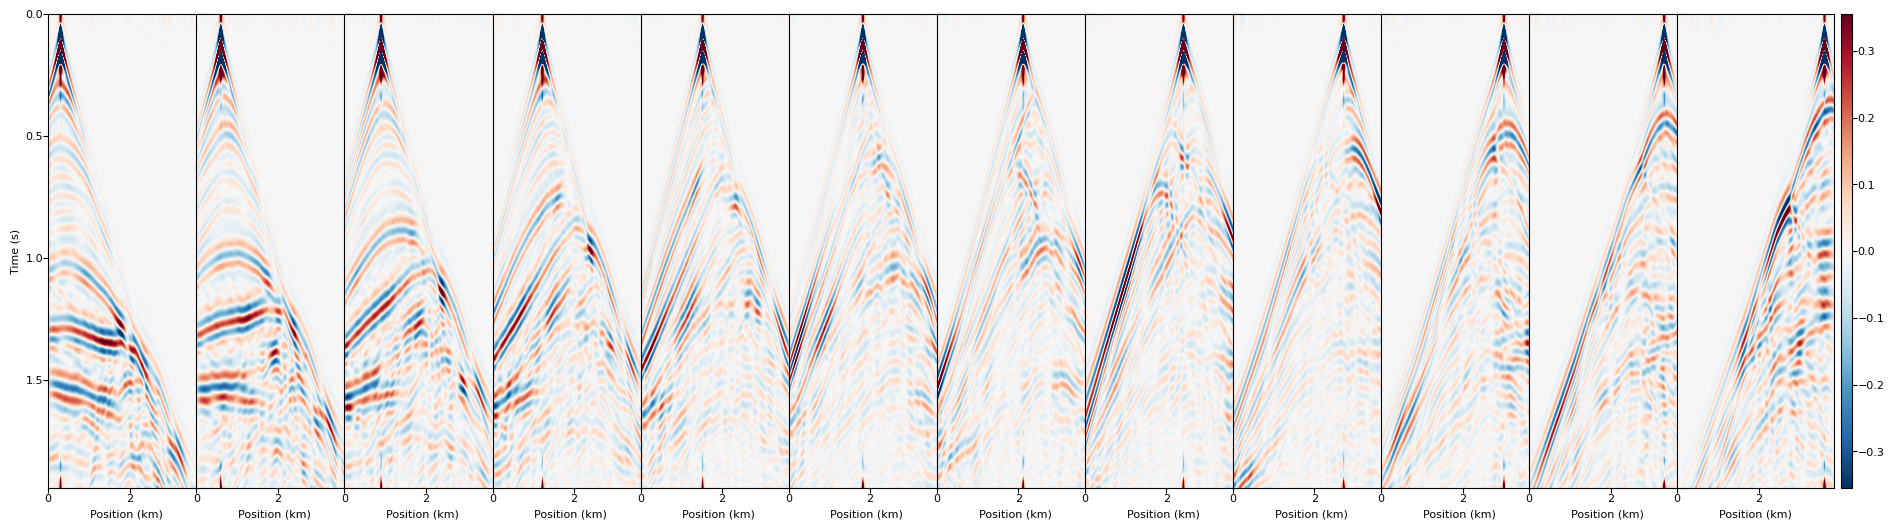

In [72]:
fig=plt.figure(figsize=(ns*1.5, 8))
imagesc(fig,
        shots_wo_low.cpu().numpy().reshape(-1, ns, nt, nx),
        vmin=-shots_wo_low.max()/30,
        vmax=shots_wo_low.max()/30,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=6,
        nRows_nCols=(1, ns),
        cmap='RdBu_r', #seismic
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), .5),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')
fig.tight_layout(pad=-0.85)

In [82]:
shots_fx_af1 =torch.fft.rfft(shots_wo_low[0,0], dim=-2).cpu().numpy()#一维傅里叶变换
shots_fx_af0 =torch.fft.rfft(shots[0,0], dim=-2).cpu().numpy()#一维傅里叶变换


In [83]:
shots_fx_af.shape

(513, 256)

In [84]:
f = np.arange(0, nt/2+1) / (nt*dt)
f.max()/513*64

32.830614548066066

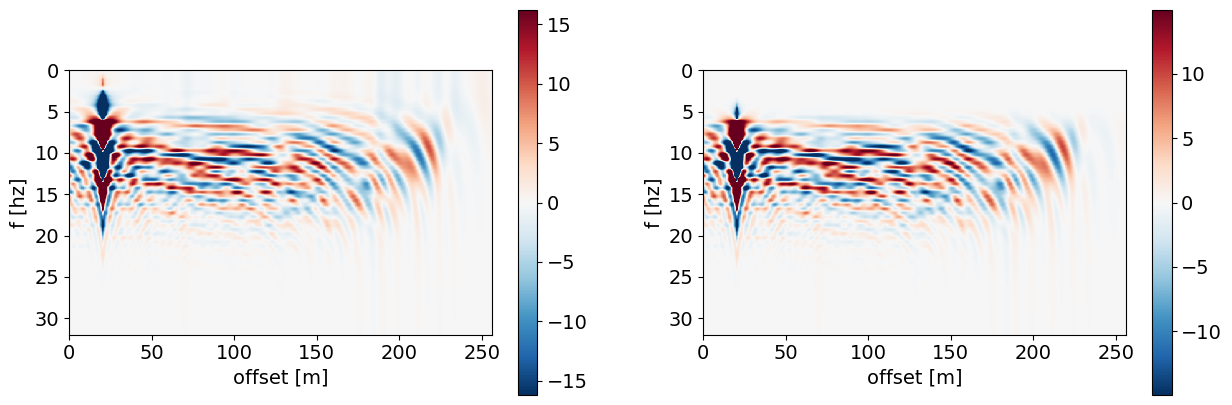

In [85]:
#未正则化
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
im = plt.imshow(shots_fx_af0[0:64,:].real, cmap='RdBu_r',
           extent=[0, 256, 32, 0], 
           aspect=5, 
           vmin=-shots_fx_af0.real.max()/20, 
           vmax=shots_fx_af0.real.max()/20
          )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("offset [m]", fontsize=14)
plt.ylabel("f [hz]", fontsize=14)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=14)

ax = fig.add_subplot(122)
im = plt.imshow(shots_fx_af1[0:64,:].real, cmap='RdBu_r',
           extent=[0, 256, 32, 0], 
           aspect=5, 
           vmin=-shots_fx_af1.real.max()/20, 
           vmax=shots_fx_af1.real.max()/20
          )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("offset [m]", fontsize=14)
plt.ylabel("f [hz]", fontsize=14)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=14)

In [9]:
import torch
from torch import nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Sequential(nn.Conv2d(in_channels, 
                                             out_channels, 
                                             kernel_size=k_size, 
                                             stride=stride, 
                                             padding=padding),
                                   nn.BatchNorm2d(out_channels),
                                   nn.LeakyReLU()
                                  )
        
    def forward(self, x):
        out = self.conv(x)
        return out
    
    
class TransConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k_size=3, stride=2, padding=1):
        super(TransConvBlock, self).__init__()
        
        self.transconv = nn.Sequential(nn.ConvTranspose2d(in_channels, 
                                                          out_channels, 
                                                          kernel_size=k_size, 
                                                          stride=stride, 
                                                          padding=padding),
                                       nn.BatchNorm2d(out_channels),
                                       nn.LeakyReLU()
                                       )
        
    def forward(self, x):
        out = self.transconv(x)
        return out
    
    
class TransConvBlock_last(nn.Module):
    def __init__(self, in_channels, out_channels, k_size=3, stride=2, padding=1):
        super(TransConvBlock_last, self).__init__()
        
        self.transconv = nn.Sequential(nn.ConvTranspose2d(in_channels, 
                                                          out_channels, 
                                                          kernel_size=k_size, 
                                                          stride=stride, 
                                                          padding=padding),
                                       nn.BatchNorm2d(out_channels)
                                       )
        
    def forward(self, x):
        out = self.transconv(x)
        return out
        

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()    
        
        #encoder--------------------------------------------                                   
        self.conv_block_1 = ConvBlock(12, 32, k_size=(4,1), stride=(2,1), padding=(1,0))      
        self.conv_block_2 = ConvBlock(32, 64, k_size=(4,1), stride=(2,1), padding=(1,0)) 
        self.conv_block_3 = ConvBlock(64, 128, k_size=4, stride=2, padding=1)          
        self.conv_block_4 = ConvBlock(128, 256, k_size=4, stride=2, padding=1)         
        self.conv_block_5 = ConvBlock(256, 512, k_size=4, stride=2, padding=1)      
        self.conv_block_6 = ConvBlock(512, 512, k_size=4, stride=2, padding=1)   
        
        #decoder--------------------------------------------                                  
        self.trans_conv_block_1 = TransConvBlock(512, 256, k_size=(1,4), stride=(1,2), padding=(0,1))                
        self.trans_conv_block_2 = TransConvBlock(256, 128, k_size=4, stride=2, padding=1)                
        self.trans_conv_block_3 = TransConvBlock(128, 64, k_size=4, stride=2, padding=1)                
        self.trans_conv_block_4 = TransConvBlock(64, 32, k_size=4, stride=2, padding=1)                      
        self.trans_conv_block_5 = TransConvBlock_last(32, 1, k_size=3, stride=1, padding=1)                
       

    def encode(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)    
        out = self.conv_block_6(x) 
        
        return out
        
        
    def decode(self, x):
        x = self.trans_conv_block_1(x)
        x = self.trans_conv_block_2(x)
        x = self.trans_conv_block_3(x)
        x = self.trans_conv_block_4(x)
        x = self.trans_conv_block_5(x)
                
        return x
    
    
    def forward(self, x):
        x = self.encode(x)
        v_pred = self.decode(x)  
       
        return v_pred
    


In [87]:
from torchinfo import summary
model = MyModel()
inputs = (1,12, 1024, 256)
summary(model, inputs)

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 1, 128, 256]          --
├─ConvBlock: 1-1                         [1, 32, 512, 256]         --
│    └─Sequential: 2-1                   [1, 32, 512, 256]         --
│    │    └─Conv2d: 3-1                  [1, 32, 512, 256]         1,568
│    │    └─BatchNorm2d: 3-2             [1, 32, 512, 256]         64
│    │    └─LeakyReLU: 3-3               [1, 32, 512, 256]         --
├─ConvBlock: 1-2                         [1, 64, 256, 256]         --
│    └─Sequential: 2-2                   [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-4                  [1, 64, 256, 256]         8,256
│    │    └─BatchNorm2d: 3-5             [1, 64, 256, 256]         128
│    │    └─LeakyReLU: 3-6               [1, 64, 256, 256]         --
├─ConvBlock: 1-3                         [1, 128, 128, 128]        --
│    └─Sequential: 2-3                   [1, 128, 128, 128]        --
│    │  

In [6]:
vp_tensor_norm = (vp_tensor - 2900)/1000

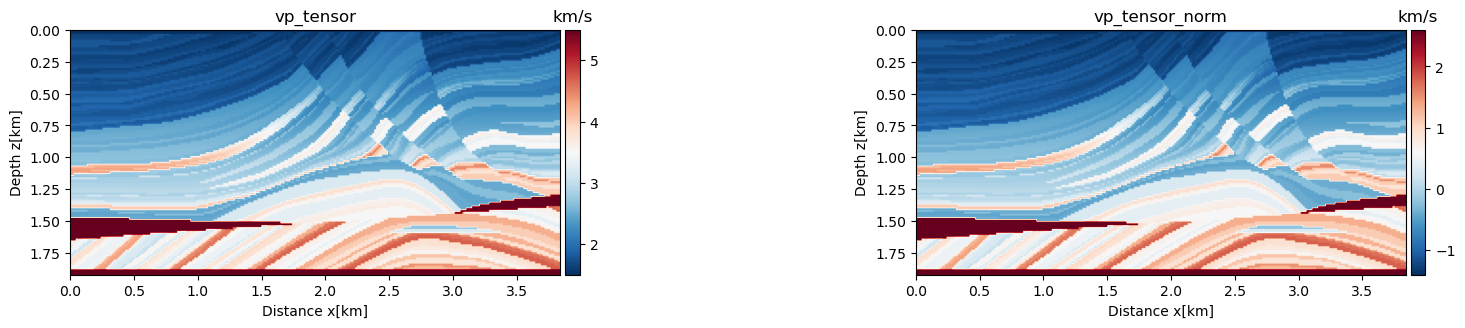

In [ ]:
fig = plt.figure(figsize=(20, 7))
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="vp_tensor")
im = ax.imshow((vp_tensor[0].cpu().detach().numpy())/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')

# 设置colorbar的取值范围
vmin = (vp_tensor[0]/1000).min() # 最小值
vmax = ((vp_tensor[0])/1000).max()   # 最大值
im.set_clim(vmin, vmax)


ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="vp_tensor_norm")
im = ax.imshow((vp_tensor_norm[0].cpu().detach().numpy()), extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')

# 设置colorbar的取值范围
vmin = (vp_tensor_norm[0]).min() # 最小值
vmax = (vp_tensor_norm[0]).max() # 最大值
im.set_clim(vmin, vmax)

In [10]:
import torchvision
# import torchvision.transforms as transforms
# torchvision.models.vgg16().features

def train(model_, data, wavelet, vi_tensor, optimizer, device='cpu'):
    
    data_resample = data[:, :, :, :]   
    data_norm = (data_resample-data.mean())/(data.std()).to(device)
   
    train_loss = 0
    data_norm = data_norm.to(device)
    optimizer.zero_grad()

    v_recon_norm = model_(data_norm) 
    v_recon = (v_recon_norm)*(1000) + 2900  
    v_recon = v_recon.to(device).type(dtype=torch.float32)

    loss_fn2 = nn.MSELoss()
    Loss2 = loss_fn2(v_recon[0], vi_tensor)
    
    loss = Loss2
    
    train_loss += loss.detach().cpu().item()
    loss.backward()
    optimizer.step()
    
    return [train_loss], v_recon[0], data

def save_state(epoch, model, optimizer, train_loss_history):
    import os
    state = {'epoch': epoch + 1,
             'train_loss_history': train_loss_history,
             'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()
             }
    torch.save(state, "./checkpoints-AE-marmousi-G-woLF/checkpoint-AE-pre-marmousi-without-low-fre8-G-{}.pth".format(epoch+1))
    if os.path.exists("./checkpoints-AE-marmousi-G-woLF/checkpoint-AE-pre-marmousi-without-low-fre8-G-{}.pth".format(epoch)):
        os.remove("./checkpoints-AE-marmousi-G-woLF/checkpoint-AE-pre-marmousi-without-low-fre8-G-{}.pth".format(epoch))

def load_state(model, optimizer, resume_file):
    checkpoint = torch.load(resume_file)
    resume_epoch = checkpoint['epoch']
    train_loss_history = checkpoint['train_loss_history']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return resume_epoch, model, optimizer, train_loss_history   


In [60]:
vi_tensor.shape

torch.Size([1, 128, 256])

In [11]:
from torch.optim.lr_scheduler import StepLR
# 预训练模型
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data = torch.load("./shots_wo_low8_marmousi_I_1024.npz").to(device).type(dtype=torch.float32) 

model = MyModel().to(device)
optimizer = torch.optim.Adam([{'params': model.parameters()}], 
                               lr=0.001, weight_decay=0.0001)

max_epoch = 1000
train_loss_history = []
print_interval = 5
for epoch in range(0, max_epoch):
   
    train_loss, v_pred, s_pred  = train(model, data, wavelet, vi_tensor, optimizer, device)
    train_loss_history.append(train_loss)
    save_state(epoch, model, optimizer, train_loss_history)
   
    if (epoch + 1) % print_interval == 0: 
        print("Epoch: {}, Training Loss: {:.8f}".format(epoch, train_loss[0]))

train_loss_history = torch.tensor(train_loss_history)


Epoch: 4, Training Loss: 576695.18750000
Epoch: 9, Training Loss: 516472.09375000
Epoch: 14, Training Loss: 430595.93750000
Epoch: 19, Training Loss: 222484.12500000
Epoch: 24, Training Loss: 148832.15625000
Epoch: 29, Training Loss: 115619.64062500
Epoch: 34, Training Loss: 74944.37500000
Epoch: 39, Training Loss: 46858.67187500
Epoch: 44, Training Loss: 37126.58593750
Epoch: 49, Training Loss: 29621.82031250
Epoch: 54, Training Loss: 25338.20507812
Epoch: 59, Training Loss: 22475.43750000
Epoch: 64, Training Loss: 20539.16015625
Epoch: 69, Training Loss: 18917.23828125
Epoch: 74, Training Loss: 17576.17382812
Epoch: 79, Training Loss: 16408.41406250
Epoch: 84, Training Loss: 15360.15136719
Epoch: 89, Training Loss: 14446.02343750
Epoch: 94, Training Loss: 13617.83984375
Epoch: 99, Training Loss: 12868.39062500
Epoch: 104, Training Loss: 12191.78808594
Epoch: 109, Training Loss: 11560.72460938
Epoch: 114, Training Loss: 10969.74511719
Epoch: 119, Training Loss: 10408.33007812
Epoch: 1

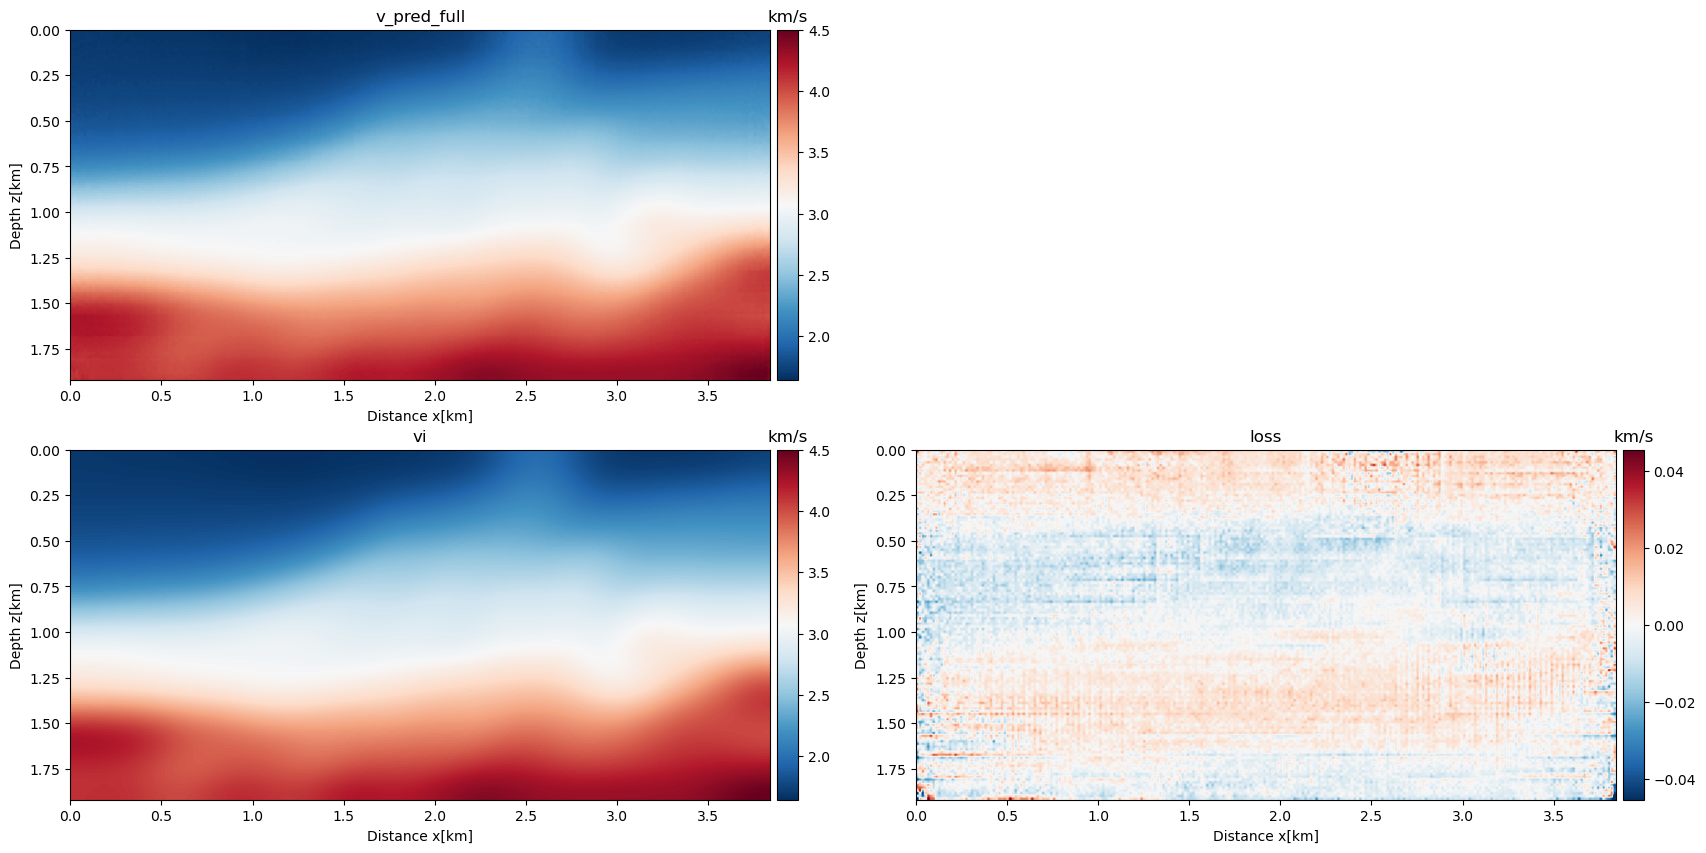

In [12]:
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="v_pred_full")
im = ax.imshow((v_pred[0].cpu().detach().numpy())/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# 设置colorbar的取值范围
vmin = (vi_tensor[0]/1000).min() # 最小值
vmax = ((vi_tensor[0])/1000).max()   # 最大值
im.set_clim(vmin, vmax)


ax = fig.add_subplot(gs[1, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="vi")
im = ax.imshow(((vi_tensor[0]).cpu().detach().numpy() )/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')


ax = fig.add_subplot(gs[1, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="loss")
im = ax.imshow(((v_pred[0]-vi_tensor[0]).cpu().detach().numpy() )/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# 设置colorbar的取值范围
vmin = -((v_pred[0]-vi_tensor[0])/1000).max()  # 最小值
vmax = ((v_pred[0]-vi_tensor[0])/1000).max()   # 最大值
im.set_clim(vmin, vmax)

In [13]:
def train(model, data, wavelet, vp_tensor, optimizer, device='cpu'):
    lamda1 = lamda2 = lamda3 = lamda4 = 1
    
    data_resample = data[:, :, :, :]   #输入的是resample后的
    # data_norm = (data-data.min())/(data.max()-data.min()).to(device)
    data_norm = (data_resample-data.mean())/(data.std()).to(device)
    
    train_loss = 0
    Loss_val = 0
    optimizer.zero_grad()

    v_recon_norm = model(data_norm)  #输出范围[-1,1]
    v_recon = (v_recon_norm)*(1000) + 2900  
    _, _, shots, _ = forward_rnn(vmodel = v_recon[0].to(device), segment_wavelet=wavelet)
    shots_resample = shots[:, :, :, :]

    data_rgb = data_resample[0][:,None,].repeat(1, 3, 1, 1)    
    shots_rgb = shots_resample[0][:,None,].repeat(1, 3, 1, 1)  
    data_rgb_norm = (data_rgb-data_rgb.mean())/(data_rgb.std()) 
    shots_rgb_norm = (shots_rgb-data_rgb.mean())/(data_rgb.std())
    data_vgg = model_vgg(data_rgb_norm)
    shots_vgg = model_vgg(shots_rgb_norm)
   
    loss_fn1 = nn.L1Loss()
    loss_fn2 = nn.MSELoss()
   
    Loss1 = loss_fn1(data_resample, shots_resample)
    Loss2 = loss_fn2(data_resample, shots_resample)
    L_recon_pixel = lamda1*Loss1 + lamda2*Loss2
    
    Loss3 = loss_fn1(data_vgg, shots_vgg)
    Loss4 = loss_fn2(data_vgg, shots_vgg)
    L_recon_perceptual = lamda3*Loss3 + lamda4*Loss4
        
    loss = L_recon_pixel + L_recon_perceptual
    
    train_loss += loss.detach().cpu().item()
    loss.backward()
    optimizer.step()
    
    Loss_val = loss_fn2(v_recon[0], vp_tensor)
    Loss_val += Loss_val.detach().cpu().item()
    return [train_loss, L_recon_pixel, L_recon_perceptual, Loss_val], v_recon[0], shots, [data.min(), data.max()]

def save_state(epoch, model, optimizer, train_loss_history):
    import os
    state = {'epoch': epoch + 1,
             'train_loss_history': train_loss_history,
             'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()
             }
    torch.save(state, "./checkpoints-AE-marmousi-G-woLF/checkpoint-AE-marmousi-without-low-fre8-G-{}.pth".format(epoch+1))
    if os.path.exists("./checkpoints-AE-marmousi-G-woLF/checkpoint-AE-marmousi-without-low-fre8-G-{}.pth".format(epoch)):
        os.remove("./checkpoints-AE-marmousi-G-woLF/checkpoint-AE-marmousi-without-low-fre8-G-{}.pth".format(epoch))
        
def load_state(model, optimizer, resume_file):
    checkpoint = torch.load(resume_file)
    resume_epoch = checkpoint['epoch']
    train_loss_history = checkpoint['train_loss_history']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return resume_epoch, model, optimizer, train_loss_history   



In [ ]:
from torch.optim.lr_scheduler import StepLR
import torchvision

# 训练模型
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
data = torch.load("./shots_wo_low8_marmousi_I_1024.npz").to(device).type(dtype=torch.float32) 

model = MyModel().to(device)
optimizer = torch.optim.Adam([{'params': model.parameters()}], 
                               lr=0.001, weight_decay=0.0001)
_, model, _, _ = load_state(model, optimizer, "./checkpoints-AE-marmousi-G-woLF/checkpoint-AE-pre-marmousi-without-low-fre8-G-1000.pth") 

optimizer = torch.optim.AdamW([{'params': model.parameters()}], 
                               lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)

model_vgg = torchvision.models.vgg16(pretrained=True).features[:13].to(device) #第13层输出--conv5的结果。

max_epoch = 3000
train_loss_history = [[], [], [], []]  
print_interval = 10
save_interval = 100
for epoch in range(0, max_epoch):
    
    train_loss, v_pred, s_pred, norm_list = train(model, data, wavelet, vp_tensor, optimizer, device)
    
    loss_test = torch.tensor(train_loss[0])
    # 检查是否有nan
    if torch.isnan(loss_test).any():
        # print('Loss is NaN - stopping training')
        break
    
    for i in range(4): 
        train_loss_history[i].append(train_loss[i]) 
        
    # 每100个epochs，保存一次模型状态
    # if epoch == 0 or (epoch + 1) % save_interval == 0:    
    save_state(epoch, model, optimizer, train_loss_history)
        
    if (epoch + 1) % print_interval == 0:  #取余数是否等于0
        print("Epoch: {}, Training Loss: {:.8f}, recon_pixel Loss: {:.8f}, recon_perceptual Loss: {:.8f}, recon_vmodel Loss: {:.8f}".format(epoch, train_loss[0], train_loss[1], train_loss[2], train_loss[3]))

train_loss_history = torch.tensor(train_loss_history)

/home/user/anaconda3/envs/torch-st/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/envs/torch-st/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 9, Training Loss: 58.47438049, recon_pixel Loss: 0.03915522, recon_perceptual Loss: 58.43522644, recon_vmodel Loss: 586070.37500000
Epoch: 19, Training Loss: 54.43127823, recon_pixel Loss: 0.03699922, recon_perceptual Loss: 54.39427948, recon_vmodel Loss: 586487.12500000
Epoch: 29, Training Loss: 52.69346619, recon_pixel Loss: 0.03613468, recon_perceptual Loss: 52.65733337, recon_vmodel Loss: 590087.00000000
Epoch: 39, Training Loss: 51.51868057, recon_pixel Loss: 0.03585219, recon_perceptual Loss: 51.48283005, recon_vmodel Loss: 598349.50000000
Epoch: 49, Training Loss: 50.69016647, recon_pixel Loss: 0.03517466, recon_perceptual Loss: 50.65499115, recon_vmodel Loss: 607888.37500000
Epoch: 59, Training Loss: 49.82048035, recon_pixel Loss: 0.03419983, recon_perceptual Loss: 49.78628159, recon_vmodel Loss: 607778.75000000
Epoch: 69, Training Loss: 48.99272156, recon_pixel Loss: 0.03366999, recon_perceptual Loss: 48.95905304, recon_vmodel Loss: 610293.62500000
Epoch: 79, Training L

In [18]:
torch.save(v_pred, './Figures/AE-G-inversion-results/v_pred_wolow8.pth')
torch.save(s_pred, './Figures/AE-G-inversion-results/s_pred_wolow8.pth')
torch.save(train_loss_history, './Figures/train_loss_history/AE_train_loss_history_wolow8.pth')


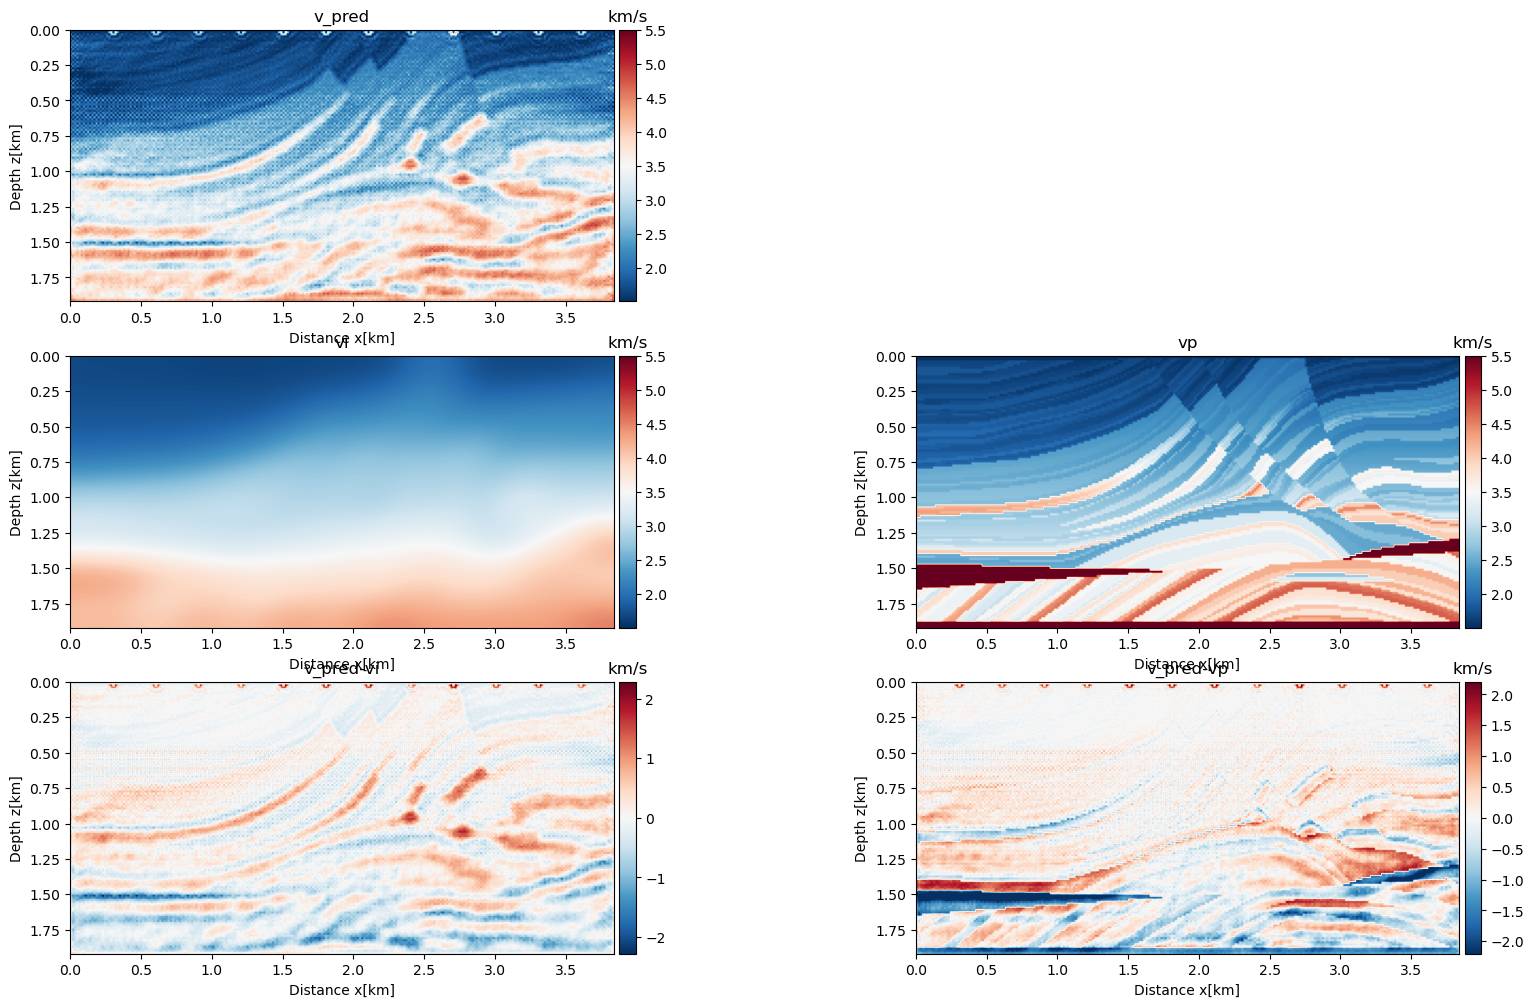

In [15]:
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="v_pred")
im = ax.imshow((v_pred[0].cpu().detach().numpy())/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# 设置colorbar的取值范围
vmin = ((vp_tensor[0])/1000).min()  # 最小值
vmax = ((vp_tensor[0])/1000).max()  # 最大值
im.set_clim(vmin, vmax)


ax = fig.add_subplot(gs[1, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="vp")
im = ax.imshow(((vp_tensor[0]).cpu().detach().numpy() )/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# 设置colorbar的取值范围
vmin = ((vp_tensor[0])/1000).min()  # 最小值
vmax = ((vp_tensor[0])/1000).max()  # 最大值
im.set_clim(vmin, vmax)

ax = fig.add_subplot(gs[1, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="vi")
im = ax.imshow(((vi_tensor[0]).cpu().detach().numpy() )/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
vmin = ((vp_tensor[0])/1000).min()  # 最小值
vmax = ((vp_tensor[0])/1000).max()  # 最大值
im.set_clim(vmin, vmax)

ax = fig.add_subplot(gs[2, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="v_pred-vp")
im = ax.imshow(((v_pred[0]-vp_tensor[0]).cpu().detach().numpy() )/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# 设置colorbar的取值范围
vmin = -((v_pred[0]-vp_tensor[0])/1000).max()  # 最小值
vmax = ((v_pred[0]-vp_tensor[0])/1000).max()   # 最大值
im.set_clim(vmin, vmax)


ax = fig.add_subplot(gs[2, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="v_pred-vi")
im = ax.imshow(((v_pred[0]-vi_tensor[0]).cpu().detach().numpy() )/1000, extent=[0, nx*dz/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# 设置colorbar的取值范围
vmin = -((v_pred[0]-vi_tensor[0])/1000).max()   # 最小值
vmax = ((v_pred[0]-vi_tensor[0])/1000).max()   # 最大值
im.set_clim(vmin, vmax)



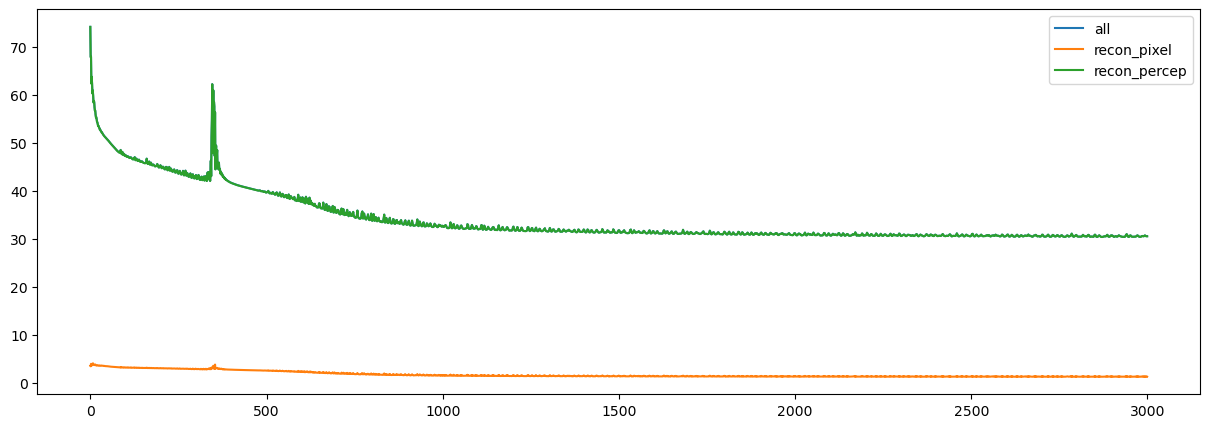

In [17]:
n=3000
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(np.arange(0,n), train_loss_history[0, 0:n].numpy(), label="all")
plt.plot(np.arange(0,n), train_loss_history[1, 0:n].numpy()*100, label="recon_pixel")
plt.plot(np.arange(0,n), train_loss_history[2, 0:n].numpy(), label="recon_percep")
plt.legend()

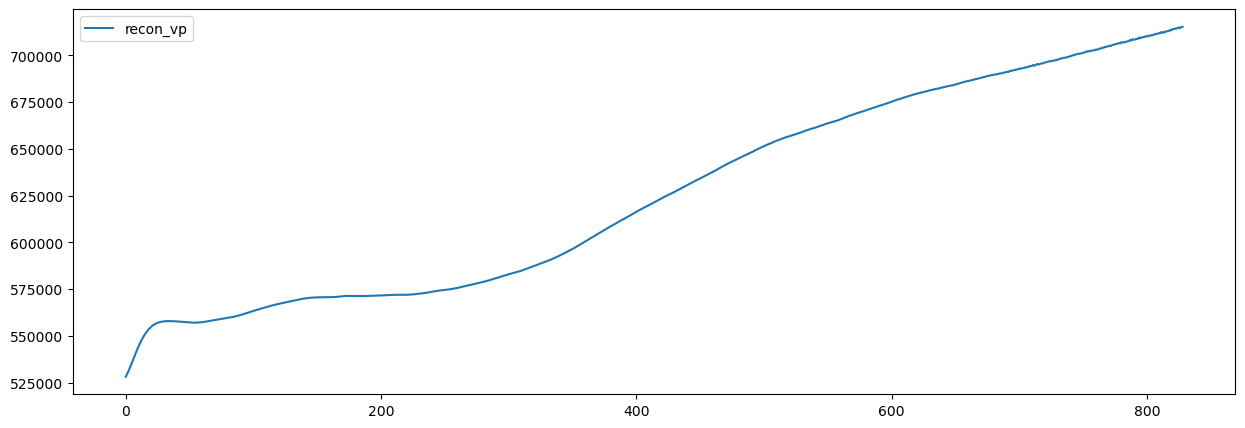

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(np.arange(0,n), train_loss_history[3, 0:n].numpy(), label="recon_vp")
plt.legend()


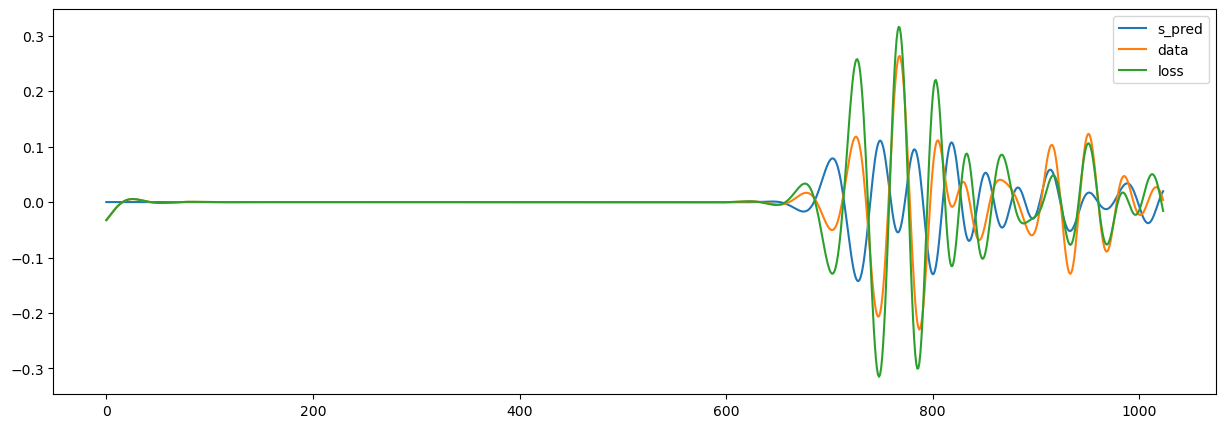

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(np.arange(0,1024), s_pred[0, 6, :, 10].detach().cpu().numpy(), label="s_pred")
plt.plot(np.arange(0,1024), data[0, 6, :, 10].detach().cpu().numpy(), label="data")
plt.plot(np.arange(0,1024), (data[0, 6, :, 10]-s_pred[0, 6, :, 10]).detach().cpu().numpy(), label="loss")

plt.legend()


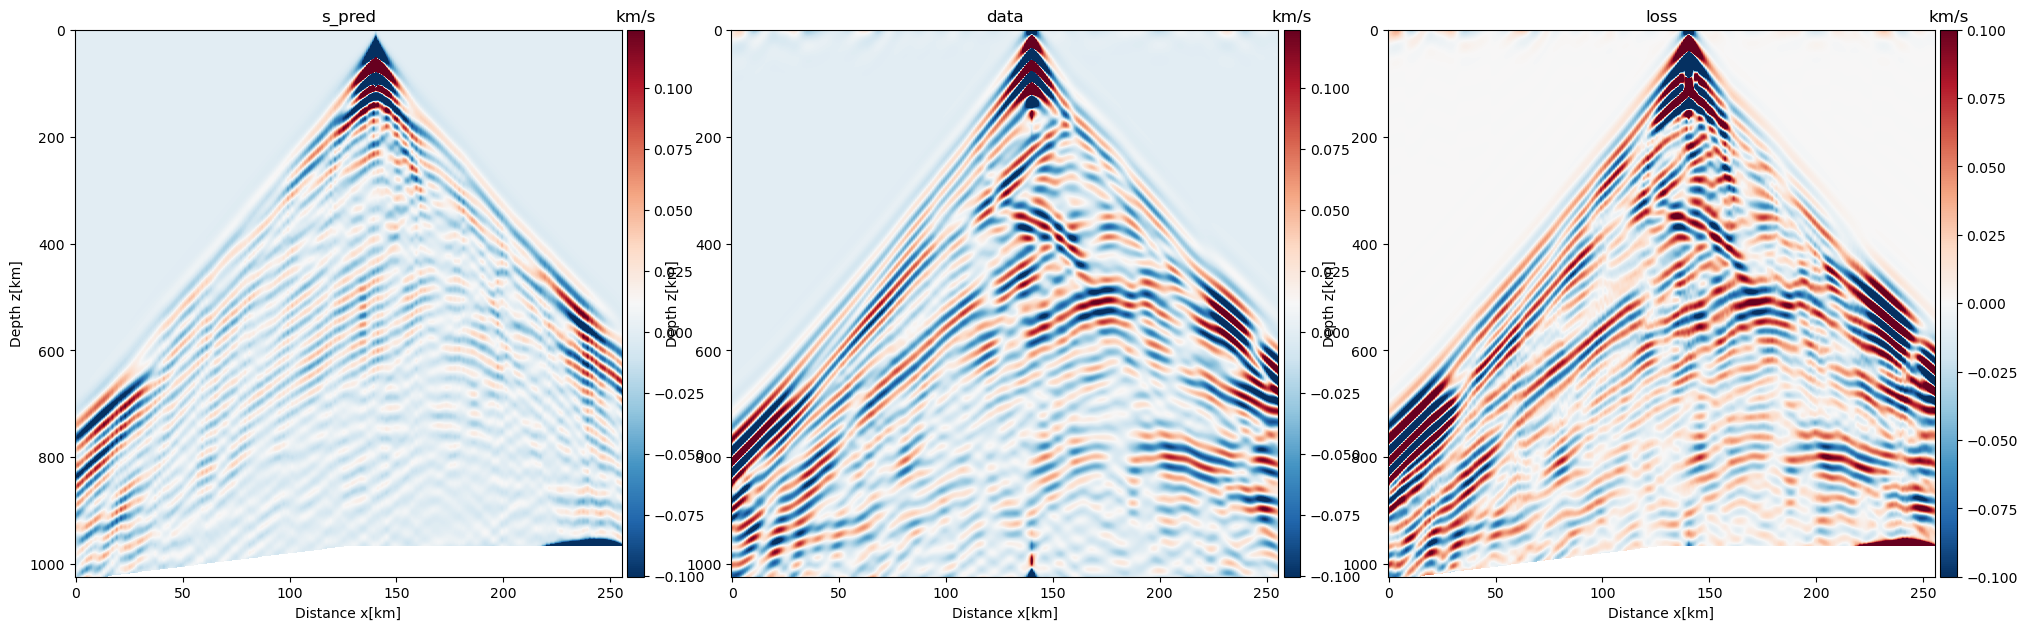

In [15]:
fig = plt.figure(figsize=(24, 10))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="s_pred")
im = ax.imshow((s_pred[0, 6].cpu().detach().numpy()), aspect=0.25, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# 设置colorbar的取值范围
vmin = ((data[0, 6])).min()/40   # 最小值
vmax = ((data[0, 6])).max()/40   # 最大值
im.set_clim(vmin, vmax)

ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="data")
im = ax.imshow(((data[0, 6]).cpu().detach().numpy()), aspect=0.25, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# 设置colorbar的取值范围
vmin = ((data[0, 6])).min()/40  # 最小值
vmax = ((data[0, 6])).max()/40  # 最大值
im.set_clim(vmin, vmax)


ax = fig.add_subplot(gs[0, 2])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="loss")
im = ax.imshow(((data[0, 6]-s_pred[0, 6]).cpu().detach().numpy()), aspect=0.25, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='km/s')
# 设置colorbar的取值范围
vmin = -((data[0, 6]-s_pred[0, 6])).max()   # 最小值
vmax = ((data[0, 6]-s_pred[0, 6])).max()   # 最大值
im.set_clim(vmin, vmax)